# Homework 5: TRPO and PPO

## Due: 23:59:59 (GMT +08:00), May 16, 2024

In this homework, you are required to implement the TRPO and PPO algorithms for the gym CartPole-v0 environment. In this problem, a pole is attached by an unactuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

<div style="text-align: center;">
    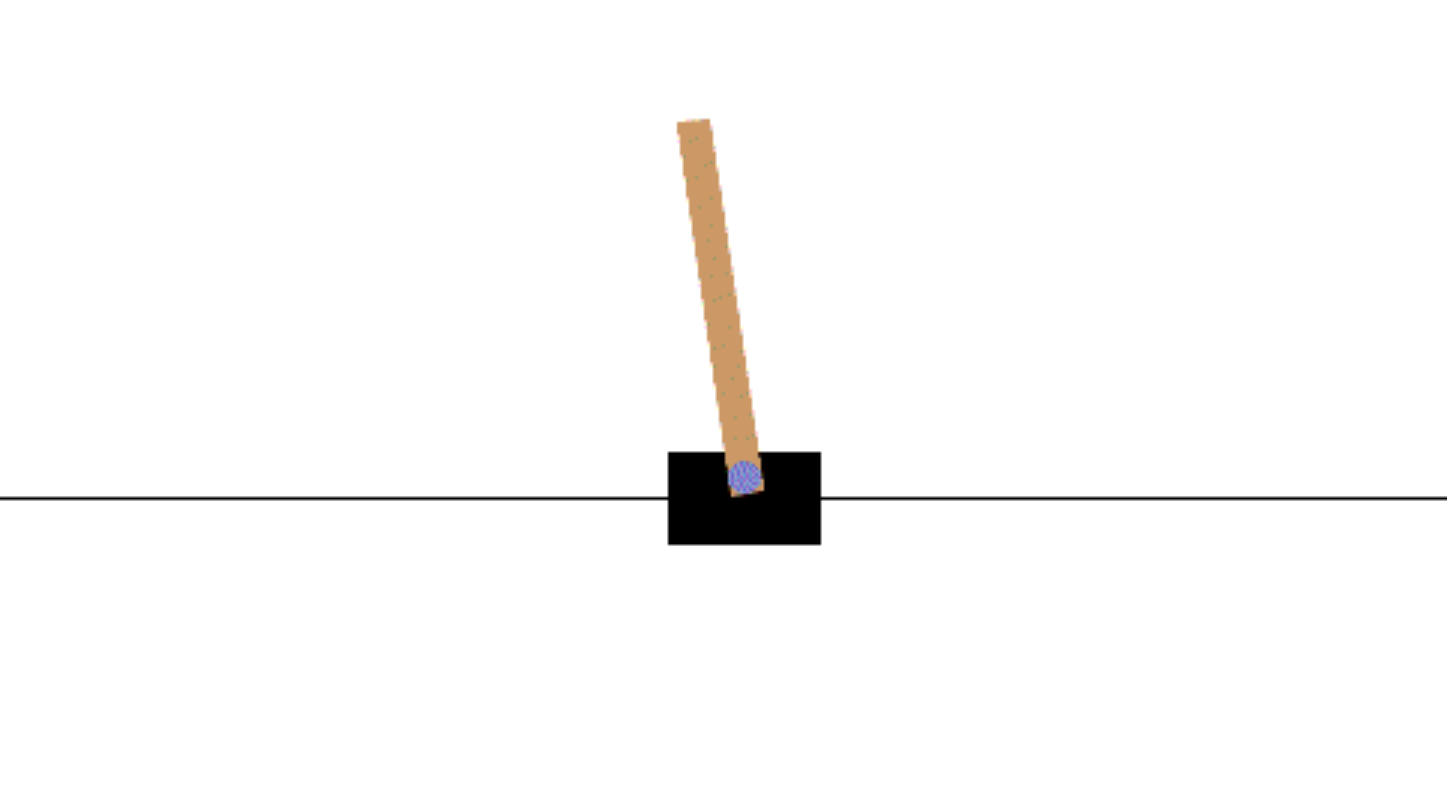
    <figcaption> Figure 1: The Cart Pole environment. </figcaption>
</div>

In this environment, the observation is a ndarray with shape `(4, )` with the values corresponding to the following positions and velocities:

<div style='text-align: center; width: 100%;'>
    <table style="margin: 0 auto;">
        <caption> Table 1: Observation space for the Cart Pole environment.</caption>
        <tr>
            <th>Num</th>
            <th>Observation</th>
            <th>Min</th>
            <th>Max</th>
        </tr>
        <tr>
            <td>0</td>
            <td>Cart Position</td>
            <td>-4.8</td>
            <td>4.8</td>
        </tr>
        <tr>
            <td>1</td>
            <td>Cart Velocity</td>
            <td>-Inf</td>
            <td>Inf</td>
        </tr>
        <tr>
            <td>2</td>
            <td>Pole Angle</td>
            <td>~ -0.418 rad (-24&deg;)</td>
            <td>~ 0.418 rad (24&deg;)</td>
        </tr>
        <tr>
            <td>3</td>
            <td>Pole Angular Velocity</td>
            <td>-Inf</td>
            <td>Inf</td>
        </tr>
    </table>
</div>

The action space is a ndarray with shape `(1, )` which can take values from $\{0,1\}$ indicating the direction of the fixed force the cart is pushed with:
- $0$: push the cart to the left;
- $1$: push the cart to the right.

Below are the utilities that we will need to implement the algorithms in this homework.

In [7]:
import gym
import copy
import time
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

## Section 1: Implementation of TRPO

Here you are required to implement the TRPO algorithm. Specifically, you are required to implement:
1. the `line_search()` function to find the best hyper-parameter for actor update (you may refer to [<a href="#ref1">1</a>, Appendix C]);
2. the `policy_learn()` function to update actor policy (you may refer to [<a href="#ref1">1</a>, Section 6]);
3. the `update()` function to update the parameter of actor and critic (you may refer to [<a href="#ref1">1</a>, Section 6]).

In [8]:
class TRPO:
    def __init__(self, hidden_dim, state_space, action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda 
        self.kl_constraint = kl_constraint 
        self.alpha = alpha 
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))  
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for _ in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs, actor):  
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs, old_action_dists, max_vec): 
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        for i in range(15): 
            coef = self.alpha ** i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            """ ------------- Programming 1: implement the linear search to find best parameter for actor (you may refer to original TRPO paper, Appendix C) ------------- """
            torch.nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(new_actor(states))
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
            """ ------------- Programming 1 ------------- """
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage): 
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        """ ------------- Programming 2: implement the conjugate_gradient function, the linear search function, to update actor parameter (you may refer to original TRPO paper, Section 6) ------------- """
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / torch.dot(descent_direction, Hd) + 1e-8)
        new_para = self.line_search(states, actions, advantage, old_log_probs, old_action_dists, descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())
        """ ------------- Programming 2 ------------- """

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        """ ------------- Programming 3: Compute GAE and update the parameter of actor and critic ------------- """
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)
        """ ------------- Programming 3 ------------- """

## Section 2: Implementation of PPO

Here you are required to implement the PPO algorithm. Specifically, you are required to implement:

1. the `update()` function to update the parameter of actor and critic (you are required to implement the penalty version of PPO with fixed penalty coefficient $\beta$, and you can refer to [<a href="#ref1">2</a>, Section 4]).

In [9]:
class PPO:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, beta, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.beta = beta
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        """ ------------- Programming 4: Compute Advantage Function ------------- """
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
        """ ------------- Programming 4 ------------- """
        for _ in range(self.epochs):
            """ ------------- Programming 5: Update the parameter of actor and critic (you may refer to original PPO paper) ------------- """
            new_log_probs = torch.log(self.actor(states).gather(1, actions))
            new_action_dists = torch.distributions.Categorical(self.actor(states))
            ratio = torch.exp(new_log_probs - old_log_probs)
            surrogate = ratio * advantage
            penalty = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
            actor_loss = -torch.mean(surrogate - self.beta * penalty)
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
            """ ------------- Programming 5 ------------- """

## Section 3: Evaluation and Discussions

d:\Software\anaconda3\envs\pytorch\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


kl constraint: 1e-06


Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]d:\Software\anaconda3\envs\pytorch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
Iteration 9: 100%|██████████| 50/50 [00:02<00:00, 16.96it/s, episode=500, return=45.500]


kl constraint: 1e-05


Iteration 9: 100%|██████████| 50/50 [00:07<00:00,  6.46it/s, episode=500, return=199.400]


kl constraint: 0.0001


Iteration 9: 100%|██████████| 50/50 [00:08<00:00,  6.03it/s, episode=500, return=151.700]


kl constraint: 0.001


Iteration 9: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s, episode=500, return=199.500]


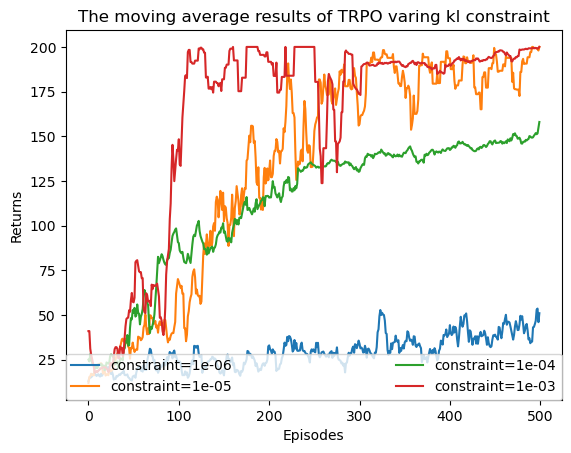

beta: 0


Iteration 9: 100%|██████████| 50/50 [00:01<00:00, 31.77it/s, episode=500, return=10.000]


beta: 10


Iteration 9: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s, episode=500, return=199.300]


beta: 100


Iteration 9: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s, episode=500, return=191.200]


beta: 1000


Iteration 9: 100%|██████████| 50/50 [00:04<00:00, 11.41it/s, episode=500, return=91.600] 


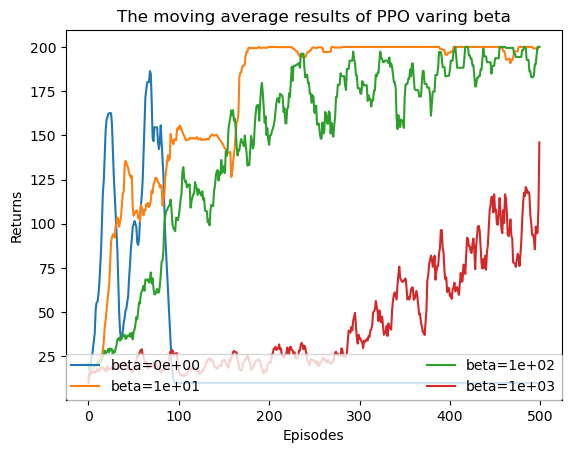

In [10]:
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98  
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# the parameters for TRPO
kl_constraint = 0.0005
alpha = 0.5
# the parameters for PPO
actor_lr = 5e-3 

env_name = 'CartPole-v0'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    update_timecost = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state, _ = env.reset(seed=1)
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done1, done2, _ = env.step(action)
                    done = done1 or done2
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                start_time = time.perf_counter()
                agent.update(transition_dict)
                end_time = time.perf_counter()
                update_timecost.append((end_time - start_time) / len(transition_dict['dones']))
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes / 10 * i + i_episode + 1), 'return': '%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    cumu_time_cost = [sum(update_timecost[0:i+1]) for i in range(len(update_timecost))]
    return return_list, cumu_time_cost

def plot_vary_beta(episodes_list_PPO, return_list_PPO_beta, beta_list):
    plt.figure()
    for i in range(len(beta_list)):
        plt.plot(episodes_list_PPO, return_list_PPO_beta[i], label=f'beta={beta_list[i]:.0e}')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.legend(loc='lower right', ncol=2, mode='expand', borderaxespad=0.)
    plt.title('The moving average results of PPO varing beta')
    plt.show()

def plot_vary_kl_constraint(episodes_list_TRPO, return_list_TRPO_constraint, kl_constraint_list):
    plt.figure()
    for i in range(len(kl_constraint_list)):
        plt.plot(episodes_list_TRPO, return_list_TRPO_constraint[i], label=f'constraint={kl_constraint_list[i]:.0e}')
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    plt.legend(loc='lower right', ncol=2, mode='expand', borderaxespad=0.)
    plt.title('The moving average results of TRPO varing kl constraint')
    plt.show()

def plot_update_time(TRPO_episode_list, TRPO_update_time, TRPO_param_list, PPO_episode_list, PPO_update_time, PPO_param_list, TRPO_param, PPO_param):
    plt.figure()
    for i in range(len(TRPO_param_list)):
        if TRPO_param_list[i] == TRPO_param:
            plt.plot(TRPO_episode_list, TRPO_update_time[i], label=f'TRPO constraint={TRPO_param_list[i]:.0e}')
            break
    for i in range(len(PPO_param_list)):
        if PPO_param_list[i] == PPO_param:
            plt.plot(PPO_episode_list, PPO_update_time[i], label=f'PPO beta={PPO_param_list[i]:.0e}')
            break
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Average Update Time')
    plt.legend(loc='lower right', ncol=2, mode='expand', borderaxespad=0.)
    plt.title(f'The cumulative average update time of TRPO PPO with Their Best Performance Param')
    plt.show()

def set_seed():
    seed = 42
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed()
kl_constraint_list = [1e-6, 1e-5, 1e-4, 1e-3]
return_list_TRPO_constraint = []
time_TRPOs = []
for kl_constraint in kl_constraint_list:
    print('kl constraint: ' + str(kl_constraint))
    agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device)
    return_list_TRPO, time_TRPO = train_on_policy_agent(env, agent, num_episodes)
    time_TRPOs.append(time_TRPO)
    episodes_list_TRPO = list(range(len(return_list_TRPO)))
    mv_return_TRPO = moving_average(return_list_TRPO, 9)
    return_list_TRPO_constraint.append(mv_return_TRPO)
plot_vary_kl_constraint(episodes_list_TRPO, return_list_TRPO_constraint, kl_constraint_list)

set_seed()
beta_list = [0, 10, 100, 1000]
return_list_PPO_beta = []
time_PPOs = []
for beta in beta_list:
    print('beta: ' + str(beta))
    agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda, epochs, beta, gamma, device)
    return_list_PPO, time_PPO = train_on_policy_agent(env, agent, num_episodes)
    time_PPOs.append(time_PPO)
    episodes_list_PPO = list(range(len(return_list_PPO)))
    mv_return_PPO = moving_average(return_list_PPO, 9)
    return_list_PPO_beta.append(mv_return_PPO)
plot_vary_beta(episodes_list_PPO, return_list_PPO_beta, beta_list)

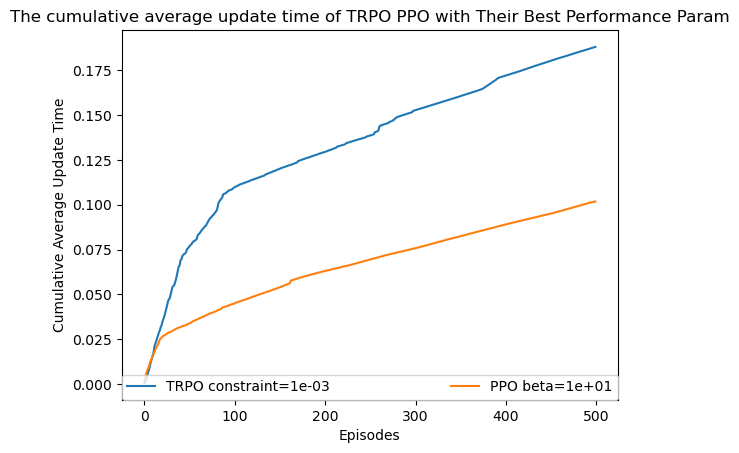

In [12]:
plot_update_time(
    episodes_list_TRPO,
    time_TRPOs,
    kl_constraint_list,
    episodes_list_PPO,
    time_PPOs,
    beta_list,
    TRPO_param=1e-3, # Please fill here the parameter with the best performance for TRPO above
    PPO_param=10, # Please fill here the parameter with the best performance for PPO above
)

In this section, please run your codes to show the performances of TRPO and PPO in the above environment and answer the following questions:

1. Compare the performance of TRPO algorithms with different values of trust region constraints, i.e., $\delta$ in <a href="#ref1">1</a>. Discuss the reason for this difference.
   * We can see that as the value of $\delta$ increases, the TRPO algorithm converges faster and achieves a higher performance within the same number of episodes.
   * The reason for this difference is that the trust region constraint $\delta$ restricts the KL-divergence between the old policy and the new policy. A smaller value of $\delta$ limits the update of the policy, which may lead to slower convergence. Therefore, as long as the trust region ensures the safety of the policy update, a larger value of $\delta$ is preferred to achieve a better performance.
2. Compare the performance of PPO algorithms with different values of penalty coefficients in the KL-divergence term, i.e., $\beta$ in <a href="#ref1">2</a>. Discuss the reason for this difference.
   * We can see that as the value of $\beta$ decreases, the PPO algorithm converges faster and achieves a higher performance within the same number of episodes. However, when $\beta$ is set to $0$, the PPO algorithm fails to learn a successful policy.
   * The reason for this difference is that the penalty coefficient $\beta$ controls the trade-off between the policy update and the KL-divergence constraint. A larger value of $\beta$ means a larger penalty for the the policy update, which may lead to slower convergence. However, when $\beta$ is set to $0$, the KL-divergence constraint is removed and the PPO algorithm drops back to A2C, which may fail to learn a successful policy. Therefore, a moderate value of $\beta$ is preferred to achieve the best performance.
3. Are the impacts of parameter $\delta$ on TRPO algorithms and the impacts of parameter $\beta$ on PPO algorithms similar or not? Discuss the reason.
   * To some extent, the impacts of parameter $\delta$ on TRPO algorithms and the impacts of parameter $\beta$ on PPO algorithms are similar because both of them are used to control the range of the policy update.
   * However, the difference is that the value of $\delta$ is negatively correlated with the KL-divergence constraint, while the value of $\beta$ is positively correlated with the KL-divergence constraint. Therefore, their impacts are in opposite directions.
4. Compare the update time cost for TRPO and PPO with their own parameters ($\delta$ or $\beta$) that shows the best performance. Which algorithm shows less time cost to update? Discuss the reason for your observation.
   * We can see that the PPO algorithm shows less time cost to update compared to the TRPO algorithm.
   * The reason for this observation is that the TRPO algorithm tries to solve a constrained optimization problem. Despite the approximate solution is employed, many tricks including line search and conjugate gradient are required to update the policy, which brings a higher time consumption. In contrast, the PPO algorithm introduces a penalty term to the objective function, which converts the constrained optimization problem into an unconstrained optimization problem, so the policy update is simplified and the time consumption is reduced.

## References

<ol>
    <li id="ref1">J. John Schulman, Sergey Levine, Pieter Abbeel, Michael Jordan, and Philipp Moritz. Trust region policy optimization. In International conference on machine learning, pages 1889 1897. PMLR, 2015.</li>
    <li id="ref2">J. John Schulman, Filip Wolski, Prafulla Dhariwal, Alec Radford, and Oleg Klimov. Proximal policy optimization algorithms. arXiv preprint arXiv:1707.06347, 2017.</li>
</ol>